In [1]:
!pip install h5py


[notice] A new release of pip is available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from keras.models import Sequential 
from keras.layers import Dense, GRU, Dropout 
from keras.optimizers import SGD 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(SEED = 42):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [117]:
#병원 별로 데이터를 나누어줌
empty_emer = pd.read_csv('../DAT/empty_emer.csv',encoding = 'CP949')
empty_emer1=empty_emer.loc[empty_emer.hospital_name=='의료법인강릉동인병원'].copy()
empty_emer2=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도강릉의료원'].copy()
empty_emer3=empty_emer.loc[empty_emer.hospital_name=='강릉아산병원'].copy()
empty_emer4=empty_emer.loc[empty_emer.hospital_name=='근로복지공단동해병원'].copy()
empty_emer5=empty_emer.loc[empty_emer.hospital_name=='의료법인동해동인병원'].copy()
empty_emer6=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도삼척의료원'].copy()
empty_emer7=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도속초의료원'].copy()
empty_emer8=empty_emer.loc[empty_emer.hospital_name=='의료법인보광의료재단속초보광병원'].copy()
empty_emer9=empty_emer.loc[empty_emer.hospital_name=='의료법인성심의료재단양구성심병원'].copy()
empty_emer10=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도영월의료원'].copy()
empty_emer11=empty_emer.loc[empty_emer.hospital_name=='강원특별자치도원주의료원'].copy()
empty_emer12=empty_emer.loc[empty_emer.hospital_name=='의료법인성지의료재단성지병원'].copy()
empty_emer13=empty_emer.loc[empty_emer.hospital_name=='연세대학교원주세브란스기독병원'].copy()
empty_emer14=empty_emer.loc[empty_emer.hospital_name=='근로복지공단정선병원'].copy()
empty_emer15=empty_emer.loc[empty_emer.hospital_name=='철원병원'].copy()
empty_emer16=empty_emer.loc[empty_emer.hospital_name=='강원대학교병원'].copy()
empty_emer17=empty_emer.loc[empty_emer.hospital_name=='한림대학교춘천성심병원'].copy()
empty_emer18=empty_emer.loc[empty_emer.hospital_name=='근로복지공단태백병원'].copy()
empty_emer19=empty_emer.loc[empty_emer.hospital_name=='평창군보건의료원'].copy()
empty_emer20=empty_emer.loc[empty_emer.hospital_name=='홍천아산병원'].copy()
empty_emer21=empty_emer.loc[empty_emer.hospital_name=='화천군보건의료원'].copy()
empty_emer22=empty_emer.loc[empty_emer.hospital_name=='횡성대성병원'].copy()

In [118]:
dflist = {'의료법인강릉동인병원':empty_emer1.copy(),
         '강원특별자치도강릉의료원':empty_emer2.copy(),
         '강릉아산병원':empty_emer3.copy(),
         '근로복지공단동해병원':empty_emer4.copy(),
         '의료법인동해동인병원':empty_emer5.copy(),
         '강원특별자치도삼척의료원':empty_emer6.copy(),
         '강원특별자치도속초의료원':empty_emer7.copy()}
# df로 병원데이터 저장
for i in dflist:
    dflist[i] = dflist[i].drop('hospital_name',axis=1, inplace=False)
    dflist[i]['record_time']=pd.to_datetime(dflist[i]['record_time'], format = '%Y%m%d%H%M%S')
    dflist[i]=dflist[i].set_index('record_time')

<AxesSubplot:xlabel='record_time'>

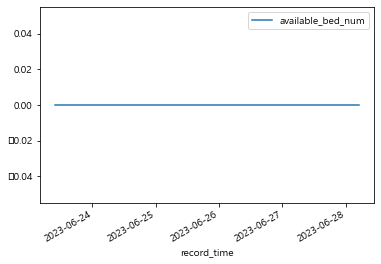

In [119]:
dflist['의료법인동해동인병원'].plot()

의료법인동해동인병원 제거

In [120]:
dflist = {'의료법인강릉동인병원':empty_emer1.copy(),
         '강원특별자치도강릉의료원':empty_emer2.copy(),
         '강릉아산병원':empty_emer3.copy(),
         '근로복지공단동해병원':empty_emer4.copy(),
         '강원특별자치도삼척의료원':empty_emer6.copy(),
         '강원특별자치도속초의료원':empty_emer7.copy()}

# df로 병원데이터 저장
for i in dflist:
    dflist[i] = dflist[i].drop('hospital_name',axis=1, inplace=False)
    dflist[i]['record_time']=pd.to_datetime(dflist[i]['record_time'], format = '%Y%m%d%H%M%S')
    dflist[i]=dflist[i].set_index('record_time')

## 함수 정의


In [8]:
# training 데이터의 samples 와 time steps로 원본데이터 슬라이싱 함수
def xysplit_data(train_data_scaled, test_data_scaled, 
                 train_data_len, test_data_len, time_steps, for_periods):
    x_train = [] 
    y_train = []  

    for i in range(time_steps, train_data_len):
        x_train.append(train_data_scaled[i-time_steps:i].copy())
        y_train.append(train_data_scaled[i:i+for_periods].values[0][0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # 3차원으로 재구성하기
    # x_train
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
    # X_test 
    inputs = pd.concat((train_data_scaled, test_data_scaled), axis=0).values
    inputs = inputs[len(inputs)-len(test_data_scaled) - time_steps:]
    inputs = inputs.reshape(-1,1)

    x_test = []
    for i in range(time_steps, test_data_len + time_steps):
        x_test.append(inputs[i-time_steps:i,0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
  
    return(x_train, y_train, x_test)

In [9]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
    actual_pred['available_bed_num'] = test_data[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['available_bed_num']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot(figsize = (20, 5)))

In [10]:
def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [11]:
def result_GRU(GRU_prediction, train_GRU_prediction, test_data):
    # GRU 결과 플롯 그리기
    GRU_prediction[1:10]
    actual_pred_plot(GRU_prediction)

    # 예측 성능 지표로 GRU 수행 결과 확인하기
    y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
    y_test_gru=test_data[0:len(GRU_prediction)]
    y_test_gru.reset_index(drop=True, inplace=True)
    test_result = confirm_result(y_test_gru, y_pred_gru)

    train_pred_gru = pd.DataFrame(train_GRU_prediction[:, 0])
    y_train_gru=train_data[time_steps:]
    y_train_gru.reset_index(drop=True, inplace=True)
    train_result = confirm_result(y_train_gru, train_pred_gru)

    test_result.columns = ['test result']
    train_result.columns = ['train result']
    total_result = pd.concat([test_result, train_result], axis = 1)
    print(total_result)

# 1. 의료법인강릉동인병원

In [12]:
dflist['의료법인강릉동인병원'].head()

,available_bed_num
record_time,
2023-06-23 09:43:52,15
2023-06-23 09:56:42,14
2023-06-23 10:04:52,14
2023-06-23 10:14:13,14
2023-06-23 10:25:53,15


In [121]:
data = dflist['의료법인강릉동인병원'].copy()

In [14]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


<AxesSubplot:xlabel='record_time'>

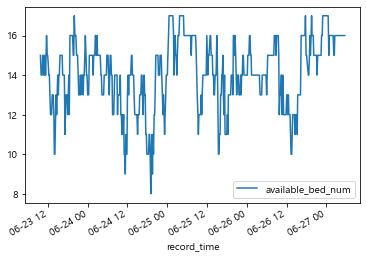

In [15]:
train_data.plot()

In [16]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [17]:
time_steps=24
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [18]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(517, 24, 1)

In [19]:
x_test.shape

(135, 24, 1)

GRU 모델 만들기

In [20]:
x_train.shape[1]

24

In [21]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh', ))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 5ms/step


       test result  train result
MAE        0.57435       0.56338
RMSE       0.80845       0.83017
RMSLE      0.05730       0.05934
R2         0.80025       0.77786


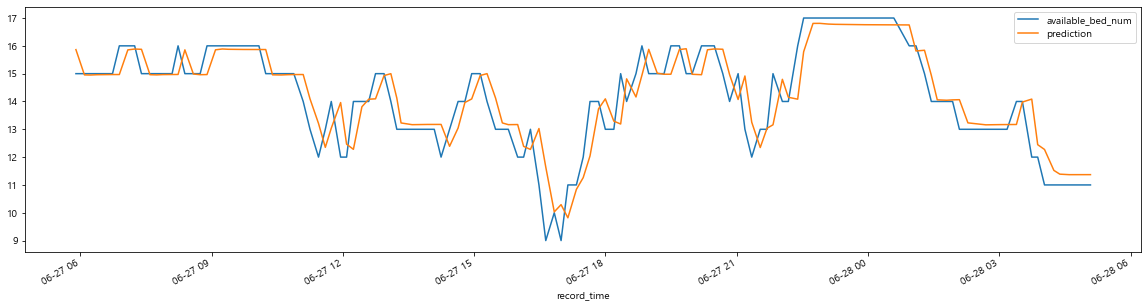

In [22]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 2. 강원특별자치도강릉의료원

In [60]:
dflist['강원특별자치도강릉의료원'].head()

,available_bed_num
record_time,
2023-06-23 09:40:01,4
2023-06-23 09:55:01,4
2023-06-23 10:05:01,4
2023-06-23 10:10:01,4
2023-06-23 10:25:01,4


In [61]:
data = dflist['강원특별자치도강릉의료원'].copy()

In [62]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


<AxesSubplot:xlabel='record_time'>

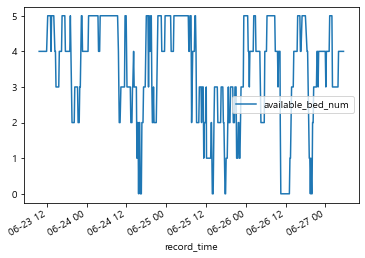

In [63]:
train_data.plot()
plt.title('강원특별자치도강릉의료원')

In [64]:
data[data['available_bed_num']<0]=0

<AxesSubplot:xlabel='record_time'>

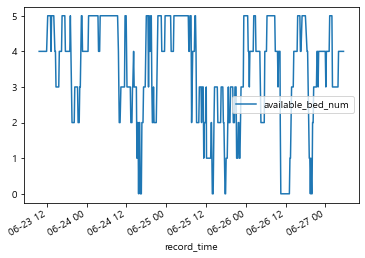

In [63]:
train_data.plot()
plt.title('강원특별자치도강릉의료원')

In [65]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [66]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [67]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(535, 6, 1)

In [68]:
x_test.shape

(135, 6, 1)

GRU 모델 만들기

In [69]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 4ms/step


       test result  train result
MAE        0.26302       0.35980
RMSE       0.43613       0.61727
RMSLE      0.11481       0.20977
R2         0.84793       0.81215


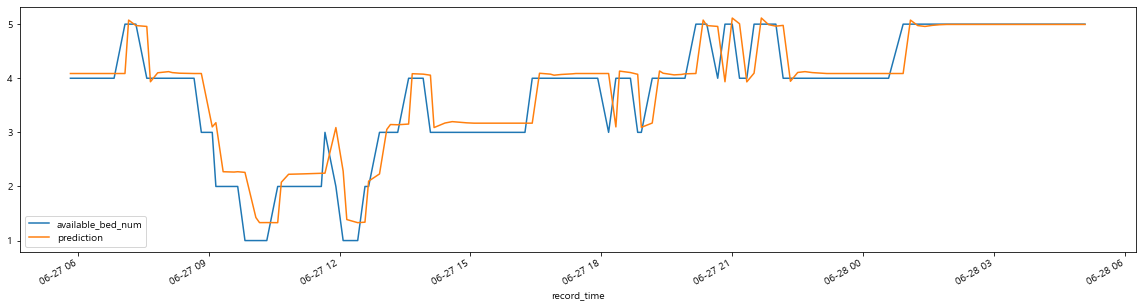

In [70]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 3. 강릉아산병원

In [122]:
dflist['강릉아산병원'].head()

,available_bed_num
record_time,
2023-06-23 09:40:01,10
2023-06-23 09:55:01,7
2023-06-23 10:05:01,6
2023-06-23 10:10:01,4
2023-06-23 10:25:01,3


In [123]:
data = dflist['강릉아산병원'].copy()

Text(0.5, 1.0, '강릉아산병원')

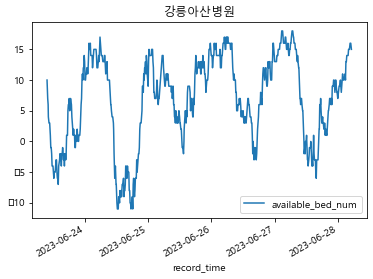

In [134]:
data.plot()
plt.title('강릉아산병원')

In [139]:
data[data['available_bed_num']<0] = 0

Text(0.5, 1.0, '강릉아산병원')

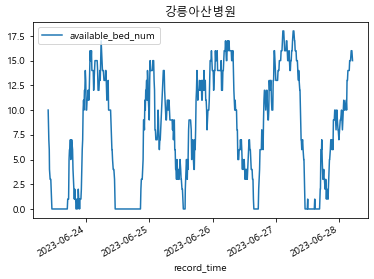

In [140]:
data.plot()
plt.title('강릉아산병원')

In [141]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


In [142]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [143]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [144]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(535, 6, 1)

In [145]:
x_test.shape

(135, 6, 1)

GRU 모델 만들기

In [146]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 3ms/step


In [151]:
GRU_prediction[GRU_prediction<0] = 0
train_GRU_prediction[train_GRU_prediction<0] = 0

       test result  train result
MAE        0.75365       0.82064
RMSE       1.03756       1.12515
RMSLE      0.26382       0.22172
R2         0.96804       0.96154


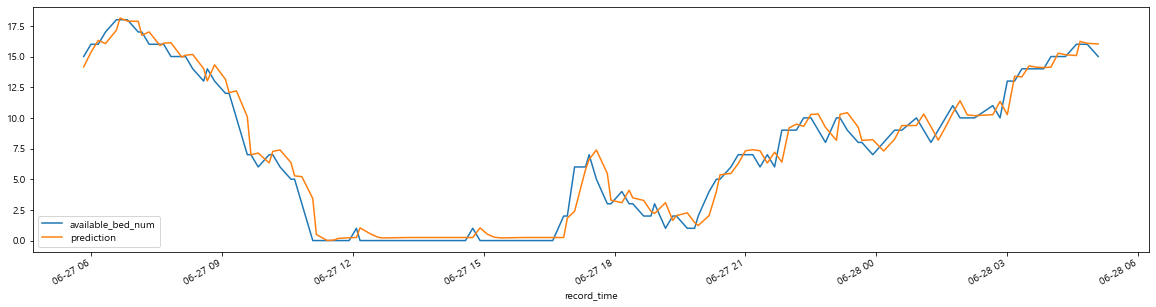

In [152]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 3. 근로복지공단동해병원

In [153]:
dflist['근로복지공단동해병원'].head()

,available_bed_num
record_time,
2023-06-23 09:41:00,4
2023-06-23 09:53:00,4
2023-06-23 10:02:00,4
2023-06-23 10:11:00,4
2023-06-23 10:23:00,4


In [154]:
data = dflist['근로복지공단동해병원'].copy()

Text(0.5, 1.0, '근로복지공단동해병원')

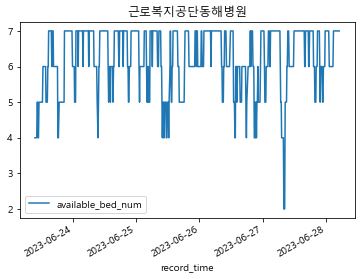

In [155]:
data.plot()
plt.title('근로복지공단동해병원')

In [156]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


In [157]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [158]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [159]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(535, 6, 1)

In [160]:
x_test.shape

(135, 6, 1)

GRU 모델 만들기

In [161]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 4ms/step


       test result  train result
MAE        0.35836       0.35462
RMSE       0.52872       0.50455
RMSLE      0.09771       0.07505
R2         0.73451       0.65200


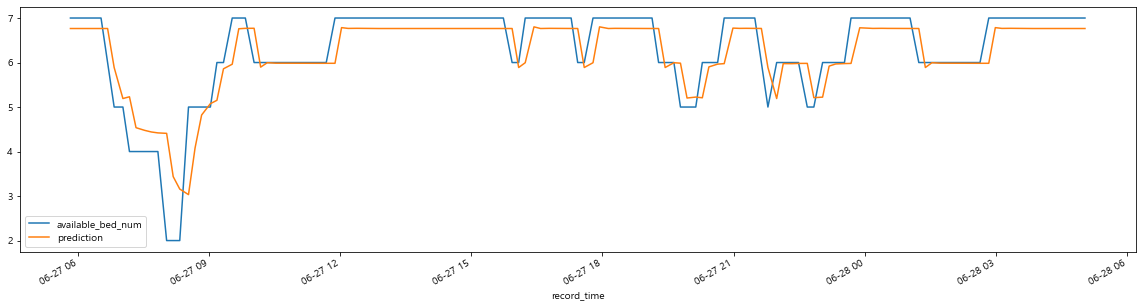

In [162]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 5. 강원특별자치도삼척의료원

In [163]:
dflist['강원특별자치도삼척의료원'].head()

,available_bed_num
record_time,
2023-06-23 09:40:01,12
2023-06-23 09:55:01,10
2023-06-23 10:00:02,10
2023-06-23 10:10:01,11
2023-06-23 10:25:01,12


In [164]:
data = dflist['강원특별자치도삼척의료원'].copy()

Text(0.5, 1.0, '강원특별자치도삼척의료원')

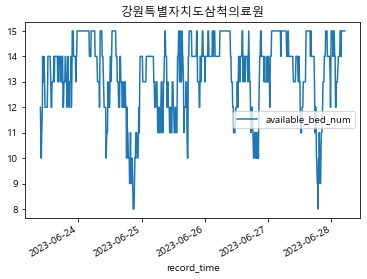

In [165]:
data.plot()
plt.title('강원특별자치도삼척의료원')

In [166]:
data[data['available_bed_num']<0] = 0

Text(0.5, 1.0, '강원특별자치도삼척의료원')

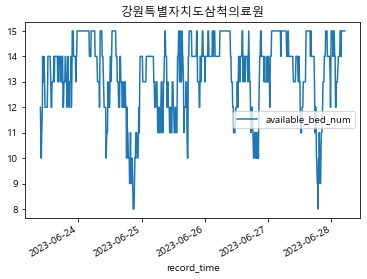

In [167]:
data.plot()
plt.title('강원특별자치도삼척의료원')

In [168]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


In [169]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [170]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [171]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(535, 6, 1)

In [172]:
x_test.shape

(135, 6, 1)

GRU 모델 만들기

In [173]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 4ms/step


       test result  train result
MAE        0.46473       0.49780
RMSE       0.71682       0.72733
RMSLE      0.05494       0.05411
R2         0.80581       0.76560


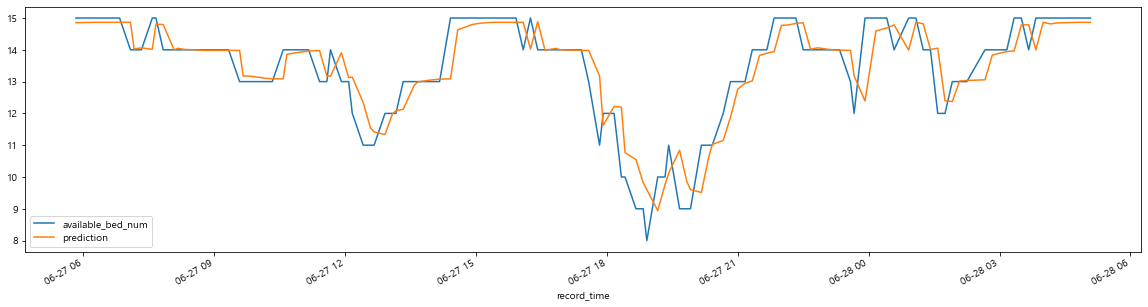

In [174]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 6. 강원특별자치도속초의료원

In [175]:
dflist['강원특별자치도속초의료원'].head()

,available_bed_num
record_time,
2023-06-23 09:40:01,18
2023-06-23 09:55:01,18
2023-06-23 10:05:01,18
2023-06-23 10:10:01,17
2023-06-23 10:25:01,17


In [176]:
data = dflist['강원특별자치도속초의료원']

Text(0.5, 1.0, '강원특별자치도삼척의료원')

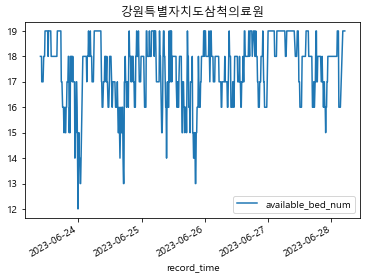

In [177]:
data.plot()
plt.title('강원특별자치도삼척의료원')

In [178]:
data[data['available_bed_num']<0] = 0

Text(0.5, 1.0, '강원특별자치도삼척의료원')

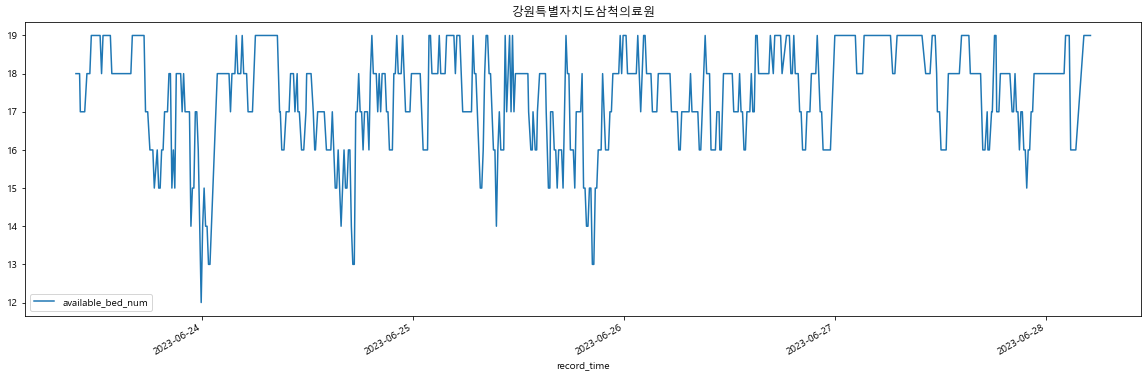

In [193]:
data.plot(figsize = (20, 6))
plt.title('강원특별자치도삼척의료원')

In [180]:
# data split
split_rate = 0.8

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


In [182]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [194]:
time_steps=20
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [195]:
x_train.shape   # 541 -1 -(6(time_steps)-1) = 535

(521, 20, 1)

In [196]:
x_test.shape

(135, 20, 1)

GRU 모델 만들기

In [201]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 100, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 50, 
                     activation = 'tanh'))
my_GRU_model.add(Dense(units = for_periods))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 70, batch_size = 20, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 13ms/step


       test result  train result
MAE        0.36502       0.54374
RMSE       0.63434       0.79361
RMSLE      0.03454       0.04526
R2         0.65561       0.64801


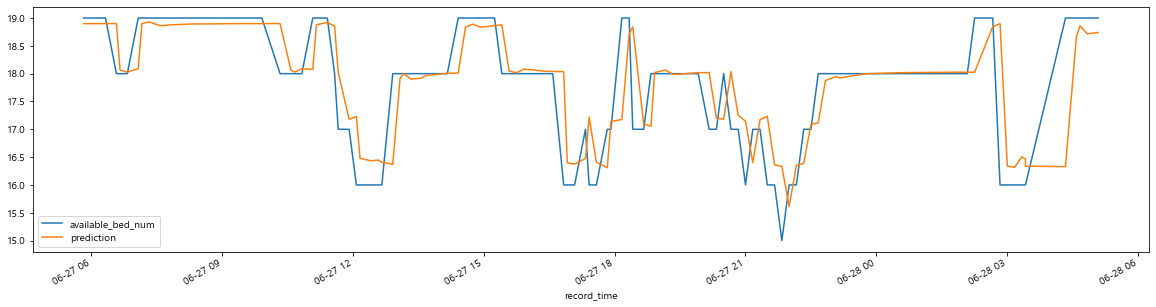

In [202]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)